In [1]:
!git clone https://github.com/arturotowers/Deep_learning.git

Cloning into 'Deep_learning'...
remote: Enumerating objects: 943, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 943 (delta 3), reused 0 (delta 0), pack-reused 928 (from 4)
Receiving objects: 100% (943/943), 144.31 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (402/402), done.


In [2]:
!pip install wandb

In [3]:
import wandb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

print(tf.__version__)

2.18.0


In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arturo-torres (arturo-torres-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Carga de imágenes

+ Para este paso vamos a cargar las imágenes almacenadas en formato .npy (ya preprocesadas).
+ Aplicaremos ruido gaussiano para generar la entrada ruidos y tener como etiqueta la imagen original limpia.

In [5]:
train_data_path = "/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/train/*/*.npy"
val_data_path   = "/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/val/*/*.npy"
test_data_path  = "/content//Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/test/*/*.npy"

In [6]:
def load_image(file_path):
    """
    Carga el archivo .npy desde la ruta dada y lo retorna como un np.array de tipo float32.
    """
    # file_path es un tensor tipo tf.string, convertimos a str en Python
    file_path = file_path.numpy().decode("utf-8")
    image = np.load(file_path).astype(np.float32)  # shape (256,256,3) según tu preprocesado
    return image

In [7]:
def load_and_preprocess(file_path):
    """
    Carga la imagen .npy, la deja en [0,1] (ya normalizada),
    y agrega ruido gaussiano. Devuelve (noisy_image, clean_image).
    """
    # tf.py_function permite usar funciones de NumPy dentro de un pipeline de tf.data
    image = tf.py_function(func=load_image, inp=[file_path], Tout=tf.float32)
    image.set_shape([256, 256, 3])  # Ajusta si tu imagen tiene otro tamaño

    clean_image = image  # La imagen limpia (original)

    # Agregar ruido gaussiano
    noise_std = 0.3  # Desviación estándar del ruido
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_std, dtype=tf.float32)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 1.0)

    return noisy_image, clean_image

In [8]:
train_file_paths = glob.glob(train_data_path, recursive=True)
val_file_paths   = glob.glob(val_data_path,   recursive=True)
test_file_paths  = glob.glob(test_data_path,  recursive=True)

print("Total imágenes (train):", len(train_file_paths))
print("Total imágenes (val):",   len(val_file_paths))
print("Total imágenes (test):",  len(test_file_paths))


Total imágenes (train): 138
Total imágenes (val): 30
Total imágenes (test): 30


In [9]:
# Convertir las rutas en tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_file_paths)
val_dataset   = tf.data.Dataset.from_tensor_slices(val_file_paths)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_file_paths)

In [10]:
# Mapear la función de carga y preprocesado (aplica ruido a cada imagen)
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(load_and_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(load_and_preprocess,  num_parallel_calls=tf.data.AUTOTUNE)


In [11]:
# Definir batch y prefetch
batch_size = 16
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Shape de noisy_batch: (16, 256, 256, 3)
Shape de clean_batch: (16, 256, 256, 3)


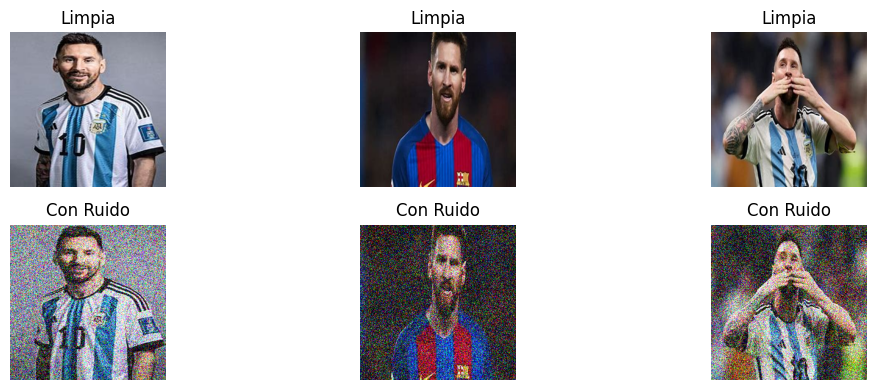

In [12]:
noisy_batch, clean_batch = next(iter(train_dataset))

print("Shape de noisy_batch:", noisy_batch.shape)   # (batch_size, 256, 256, 3)
print("Shape de clean_batch:", clean_batch.shape)   # (batch_size, 256, 256, 3)

# Mostrar 3 ejemplos
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(clean_batch[i].numpy())
    plt.title("Limpia")
    plt.axis("off")

    plt.subplot(2, 3, i+4)
    plt.imshow(noisy_batch[i].numpy())
    plt.title("Con Ruido")
    plt.axis("off")

plt.tight_layout()
plt.show()

Bien ahora que ya le agregamos ruído a nuestras imágenes y ya están preprocesadas y listas para ingresarse al modelo pasemos a ello.

Utilizaremos una arquitectura muy simple con capas convolucionales y operaciones pooling y upsampling.

In [13]:
def create_dae_model(input_shape=(256,256,3)):
    """
    Crea y devuelve un modelo Keras para Denoising Autoencoder (DAE).

    Parámetros:
    - input_shape: tupla con (altura, ancho, canales).

    Retorna:
    - model: objeto keras.Model listo para compilar.
    """
    # ENCODER
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Capa Conv 1
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)  # reduce a la mitad altura y ancho

    # Capa Conv 2
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)

    # Capa Conv 3 (Latent Space)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    # En este punto x es la representación "latente" comprimida

    # DECODER
    x = layers.UpSampling2D((2,2))(x)  # aumenta tamaño de la imagen
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)

    # Capa de salida
    outputs = layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same', name="output_image")(x)

    # Construimos el modelo
    model = keras.Model(inputs, outputs, name="DenoisingAutoencoder")
    return model


In [14]:
# Creamos el modelo
model = create_dae_model(input_shape=(256,256,3))

In [15]:
# Compilamos con optimizador Adam y pérdida MSE (para reconstrucción de imagen)
model.compile(optimizer='adam', loss='mse')

# Mostramos la arquitectura
model.summary()


Model: "DenoisingAutoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_image (Conv2D)                │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# prompt: how do I track with wandb mi model training

# Define your training loop and integrate wandb logging
def train_model(model, train_dataset, val_dataset, epochs=10):
  with wandb.init(project="VAE + DAE", entity="arturo-torres-iteso",name="DAE_train2", config={"epochs": epochs, "batch_size": batch_size}):
    config = wandb.config
    for epoch in range(config.epochs):
      for batch_idx, (noisy_batch, clean_batch) in enumerate(train_dataset):
        loss = model.train_on_batch(noisy_batch, clean_batch)
        # Log training loss to wandb
        wandb.log({"train_loss": loss, "epoch": epoch, "batch": batch_idx})

      # Evaluate on validation dataset
      val_loss = model.evaluate(val_dataset, verbose=0)
      # Log validation loss to wandb
      wandb.log({"val_loss": val_loss, "epoch": epoch})

      print(f"Epoch {epoch+1}/{config.epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")


# Call the training function
train_model(model, train_dataset, val_dataset, epochs=30)


Epoch 1/30, Loss: 0.0858, Val Loss: 0.0380
Epoch 2/30, Loss: 0.0320, Val Loss: 0.0266
Epoch 3/30, Loss: 0.0245, Val Loss: 0.0210
Epoch 4/30, Loss: 0.0196, Val Loss: 0.0155
Epoch 5/30, Loss: 0.0137, Val Loss: 0.0122
Epoch 6/30, Loss: 0.0119, Val Loss: 0.0117
Epoch 7/30, Loss: 0.0109, Val Loss: 0.0102
Epoch 8/30, Loss: 0.0096, Val Loss: 0.0093
Epoch 9/30, Loss: 0.0091, Val Loss: 0.0092
Epoch 10/30, Loss: 0.0087, Val Loss: 0.0085
Epoch 11/30, Loss: 0.0080, Val Loss: 0.0082
Epoch 12/30, Loss: 0.0078, Val Loss: 0.0083
Epoch 13/30, Loss: 0.0076, Val Loss: 0.0080
Epoch 14/30, Loss: 0.0074, Val Loss: 0.0083
Epoch 15/30, Loss: 0.0090, Val Loss: 0.0087
Epoch 16/30, Loss: 0.0076, Val Loss: 0.0079
Epoch 17/30, Loss: 0.0073, Val Loss: 0.0078
Epoch 18/30, Loss: 0.0072, Val Loss: 0.0077
Epoch 19/30, Loss: 0.0070, Val Loss: 0.0076
Epoch 20/30, Loss: 0.0072, Val Loss: 0.0076
Epoch 21/30, Loss: 0.0073, Val Loss: 0.0079
Epoch 22/30, Loss: 0.0070, Val Loss: 0.0073
Epoch 23/30, Loss: 0.0068, Val Loss: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


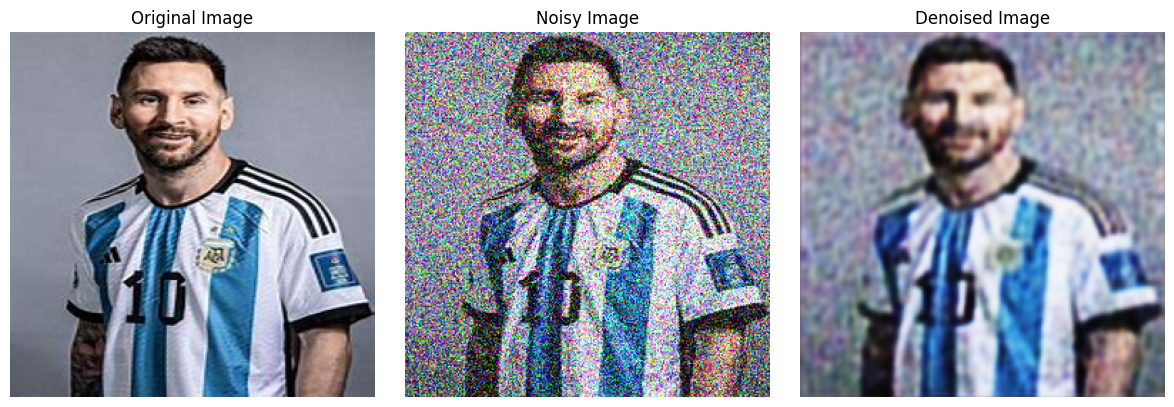

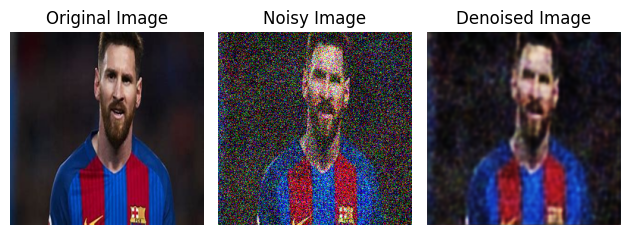

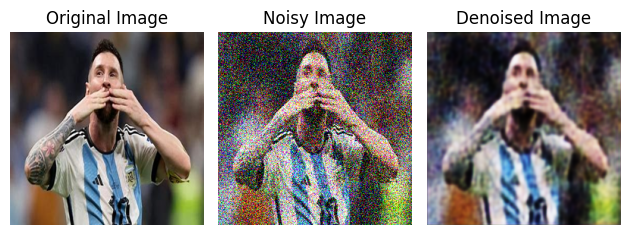

In [17]:
# prompt: How could I see the difference between the 3 types of image, a normal, noisy and denoised??

import matplotlib.pyplot as plt
# Get a batch of noisy and clean images from the training dataset
noisy_batch, clean_batch = next(iter(train_dataset))

# Predict denoised images using the trained model
denoised_batch = model.predict(noisy_batch)

# Display the original, noisy, and denoised images side by side
plt.figure(figsize=(12, 4))
for i in range(3):
  plt.subplot(1, 3, 1)
  plt.imshow(clean_batch[i].numpy())
  plt.title("Original Image")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(noisy_batch[i].numpy())
  plt.title("Noisy Image")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow(denoised_batch[i])
  plt.title("Denoised Image")
  plt.axis("off")

  plt.tight_layout()
  plt.show()


Hacemos exacatamente lo mismo pero ahora para las imagenes de prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


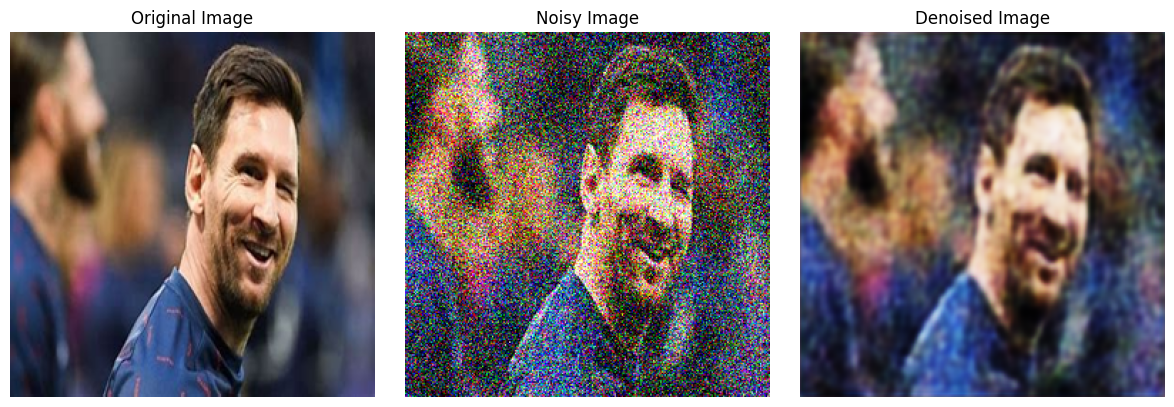

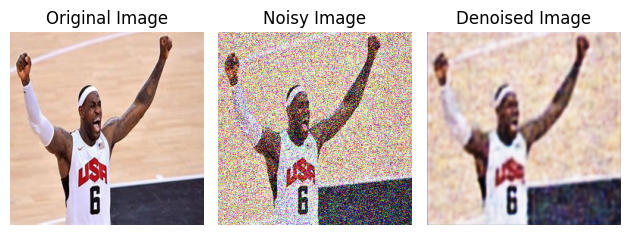

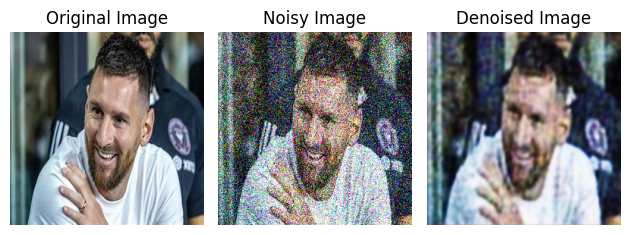

In [20]:
# Obtener un batch de imágenes de prueba
noisy_batch, clean_batch = next(iter(test_dataset))

# Predecir las imágenes denoised usando el modelo entrenado
denoised_batch = model.predict(noisy_batch)

# Mostrar las imágenes originales, ruidosas y denoised
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, 1)
    plt.imshow(clean_batch[-i].numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_batch[-i].numpy())
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_batch[-i])
    plt.title("Denoised Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Guardamos el modelo en weights and biases

In [18]:
# Guardar en formato .h5
model.save('/content/vae_dae_model.h5')

# Subir a W&B
artifact = wandb.Artifact('vae_dae_model', type='model')
artifact.add_file('/content/vae_dae_model.h5')

with wandb.init(project="VAE_DAE_Project", entity="arturo-torres-iteso"):
    wandb.log_artifact(artifact)
    print("Modelo subido exitosamente a WandB!")


Modelo subido exitosamente a WandB!


En dado caso de que quisieramos cargar el modelo haríamos lo siguiente:

In [ ]:

# run = wandb.init(project="VAE_DAE_Project", entity="arturo-torres-iteso")
# artifact = run.use_artifact('vae_dae_model:latest', type='model')
# artifact_dir = artifact.download()

# print(f'Modelo descargado en: {artifact_dir}')

# import tensorflow as tf

# # Cargar modelo en formato .h5
# model_path = f'{artifact_dir}/vae_dae_model.h5'
# model = tf.keras.models.load_model(model_path)

# print("Modelo cargado exitosamente.")

